# La patogénesis del alzhéimer: clasificación precoz mediante redes neuronales
_**Objetivo:** distinguir a sujetos que puedan desarrollar alzhéimer con una exactitud superior al 65% y una antelación al diagnóstico de más de tres años._

_**Datos** del proyecto [OASIS 3](https://www.oasis-brains.org/)._

_**Entorno de desarrollo testado:** Dispositivo con procesador Apple M1. Software base: MacOS Monterey 12.5.1 con Miniconda y [Mamba](https://mamba.readthedocs.io/en/latest/installation.html) instalados_


### Tarea previa: obtener el listados de sesiones y diagnósticos
1. Pedir acceso en https://www.oasis-brains.org/#access
2. Esperar a la concesión
3. Crear un usuario mediante el mail de confirmación recibido
4. Acceder a la plataforma [XNAT](https://central.xnat.org/)
5. Identificarse
6. Abrir el proyecto OASIS3
7. Abrir la pestaña (tab) **MR Sessions**
8. Descargar fichero CSV en: Options > Spreadsheet
9. Colocar el fichero en el mismo directorio de este notebook
10. Abrir la pestaña (tab) **ADRC Clinical Data**
11. Descargar fichero CSV en: Options > Spreadsheet
12. Colocar el fichero en el mismo directorio de este notebook

### Instalar en entorno en Mamba con las dependencias necesarias
Se proporciona un fichero de entorno con todo lo necesario llamado `mamba_environment.yml`
Para tenerlo listo, ejecutar las siguientes sentencias en la línea de comandos:

    mamba env create tf -f mamba_environment.yml
    mamba activate tf

### Obtención de datos
Del CSV de sesiones decargado (aquí llamado `oasis3_mr_list.csv`), solo necesitamos los ID de las sesiones para la descarga de IRM.

In [162]:
import pandas as pd

dfMR = pd.read_csv('oasis3_mr_list.csv')
dfSessions = dfMR[['MR ID']]
dfSessions.to_csv('oasis3_sessions_list.csv', header=None, index=False)


Para la obtención de las IRM, se utilizan los scripts oficiales que nos ofrece la plataforma XNAT.

En este caso, se van a utilizar las IRM empleadas del tipo T1w. Recomendables 50 GB de espacio.

En línea de comandos (fuera de Python), ejecutar:

    git clone https://github.com/NrgXnat/oasis-scripts.git
    sudo chmod u+x ./oasis-scripts/download_scans/download_oasis_scans.sh
    ./oasis-scripts/download_scans/download_oasis_scans.sh oasis3_sessions_list.csv scans $USUARIO_XNAT T1w

> Reemplazar `$USUARIO_XNAT` por el usuario real.

### Estandarización y preparación de diagnósticos

In [163]:
dfDiagnostics = pd.read_csv('./oasis3_diagnostic_data.csv')
print(dfDiagnostics['dx1'].unique())

['Cognitively normal' 'uncertain dementia' 'Unc: ques. Impairment'
 'AD dem w/depresss- not contribut' 'AD Dementia'
 'AD dem distrubed social- with' 'AD dem w/CVD contribut'
 'Non AD dem- Other primary' 'AD dem visuospatial- with'
 'AD dem visuospatial- prior' 'AD dem Language dysf after' '.'
 'uncertain- possible NON AD dem' 'Vascular Demt- primary'
 'AD dem w/PDI after AD dem not contrib' '0.5 in memory only'
 'Incipient Non-AD dem' 'AD dem distrubed social- prior'
 'Frontotemporal demt. prim' 'AD dem distrubed social- after'
 'AD dem w/PDI after AD dem contribut' 'uncertain  possible NON AD dem'
 'AD dem w/depresss  not contribut' 'AD dem w/oth (list B) contribut'
 'DLBD- primary' 'Incipient demt PTP' 'Dementia/PD- primary'
 'AD dem w/depresss- contribut' 'Unc: impair reversible'
 'AD dem w/oth (list B) not contrib' 'AD dem w/CVD not contrib'
 'AD dem Language dysf prior' 'AD dem Language dysf with' 'DAT'
 'Vascular Demt  primary' 'DLBD- secondary'
 'AD dem w/oth unusual features' 

In [164]:
def getBinaryDiagnostic(diagnostic):
    lowerDiag = str(diagnostic).lower()

    if 'non ad' in lowerDiag:
        return 0
    if 'non-ad' in lowerDiag:
        return 0
    if 'ad dem cannot be primary' in lowerDiag:
        return 0
    if 'ad' in lowerDiag:
        return 1
    if 'dat' in lowerDiag:
        return 1
       
    return 0

dfDiagnostics['BinaryDiag'] = dfDiagnostics['dx1'].apply(getBinaryDiagnostic)

Interesa saber los días de diagnóstico de la EA.

In [165]:
dfDiagnostics['Day'] = dfDiagnostics['ADRC_ADRCCLINICALDATA ID'].str.split('_d').str[1].astype(int)

In [166]:
def getFirstDayDiagnostic(row):
    if row['BinaryDiag'] == 1:
        return row['Day']
    
    return 0

dfDiagnostics['PositiveDay'] = dfDiagnostics.apply(lambda row: getFirstDayDiagnostic(row), axis=1)

Se registra el primer día de diagnóstico positivo.

In [167]:
dfDiagnostics['FirstPositiveDay'] = dfDiagnostics['Subject'].map(
                                        dfDiagnostics[dfDiagnostics['BinaryDiag'] == 1]
                                        .drop_duplicates(['Subject'], keep='first')
                                        .set_index('Subject')
                                        ['PositiveDay']
                                    ).fillna(0)

### Preprocesamiento del df de aprendizaje

Solo necesitamos los casos de los que hayamos logrado descargar una IRM.

In [168]:
import os

downloadedScansIDs = pd.DataFrame(os.listdir('./scans/'), columns=['MR ID'])
print(f'{downloadedScansIDs.shape} vs {dfMR.shape}')

(2832, 1) vs (2844, 8)


In [169]:
dfMR = pd.merge(dfMR, downloadedScansIDs, on=['MR ID'])
dfMR.shape

(2831, 8)

Solo interesa el último diagnóstico de cada sujeto.

In [170]:
dfDiagnostics = dfDiagnostics.sort_values('ADRC_ADRCCLINICALDATA ID')
dfDiagnostics = dfDiagnostics.drop_duplicates('Subject', keep='last')

Se omiten las sesiones de los sujetos sin diagnóstico.

In [171]:
mrSubjectsSize = dfMR['Subject'].unique().size
diagnosticsSubjectsSize = dfDiagnostics['Subject'].unique().size
print(f'MR subjects: {mrSubjectsSize} vs Diagnosis subjects: {diagnosticsSubjectsSize}')

MR subjects: 1376 vs Diagnosis subjects: 1098


In [172]:
dfMR = dfMR.merge(dfDiagnostics, on=['Subject'])
dfMR['Subject'].unique().size

1098

Se omiten los atributos que no se tiene intención de utilizar o analizar.

In [173]:
dfMR = dfMR[['MR ID', 'Subject', 'Age_x', 'BinaryDiag', 'FirstPositiveDay']]
dfMR = dfMR.rename(columns={'Age_x': 'Age'})

### Análisis descriptivo y visualizaciones iniciales

Text(0, 0.5, 'Número de sesiones')

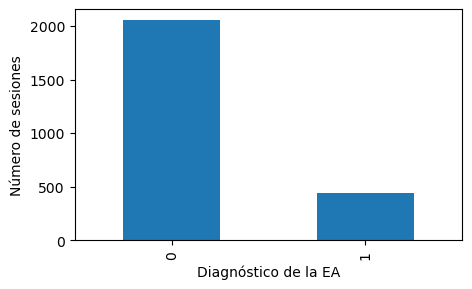

In [174]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 3]

dfMR['BinaryDiag'].value_counts().plot(kind='bar')
plt.xlabel('Diagnóstico de la EA')
plt.ylabel('Número de sesiones')

Se observa una clasificación de partida desbalanceada. Se optará por el sobremuestreo (al disponer de bastantes cortes en cada IRM).

Se visualiza y trata un muestra.

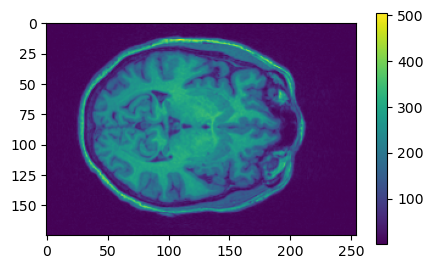

In [175]:
import nibabel as nib
import numpy as np
from skimage import transform

sample = nib.load('./scans/OAS30001_MR_d0129/anat2/sub-OAS30001_ses-d0129_run-01_T1w.nii.gz')
sampleData = sample.get_fdata()
sampleY, sampleX, sampleZ = sampleData.shape
halfCut = sampleZ // 2
sampleData = sampleData[:,:,halfCut]
sampleData = transform.resize(sampleData, (175, 255), order=1, preserve_range=True)

plt.imshow(sampleData)
plt.colorbar()

In [176]:
sampleData.shape

(175, 255)

In [177]:
min, max = sampleData.min(), sampleData.max()
print(f'Mínimo original: {min}. Máximo original: {max}')

Mínimo original: 0.00020168067226873177. Máximo original: 504.0775966386553


Es ideal normalizar la escala para hacer más eficiente el aprendizaje. Se plantea una estandarización positiva (entre 0 y 1).

In [178]:
from numpy import clip

def normalizeImageData(data):
    mean, std = data.mean(), data.std()
    standardData = (data - mean) / std
    standardData = clip(standardData, -1.0, 1.0)
    standardData = (standardData + 1.0) / 2.0

    return standardData

standardSampleData = normalizeImageData(sampleData)

min, max = standardSampleData.min(), standardSampleData.max()
print(f'Mínimo estándar: {min}. Máximo estándar: {max}')

Mínimo estándar: 0.05705619213177093. Máximo estándar: 1.0


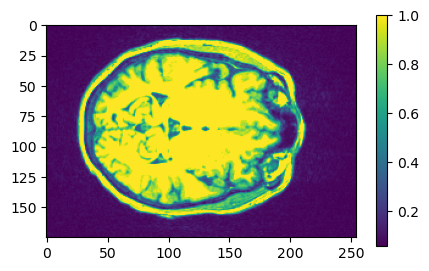

In [179]:
plt.imshow(standardSampleData)
plt.colorbar()

### Incorporación de IRM al df

Se cuadruplican los casos positivos para balancear el df.

In [180]:
def getNTimes(value):
    nTimes = 1
    if value == 1: nTimes = 4
    return nTimes

dfMR['NTimes'] = dfMR['BinaryDiag'].apply(getNTimes)
dfMR = dfMR.reindex(dfMR.index.repeat(dfMR['NTimes'])).reset_index(drop=True)
dfMR = dfMR.drop(columns={'NTimes'})
dfMR['BinaryDiag'].value_counts(normalize=True)

0    0.536534
1    0.463466
Name: BinaryDiag, dtype: float64

In [181]:
dfMR['Cut'] = dfMR.groupby(['MR ID']).cumcount()+1
dfMR['BinaryDiag'].value_counts(normalize=True)

0    0.536534
1    0.463466
Name: BinaryDiag, dtype: float64

Se incorporan las IRM al df.

- Se omiten las que tienen los planos en distino orden (se asume el último como el axial).
- Se normalizan
- Se fuerza su tamaño a 175x255

> Se propone como mejora la revisión de imágenes para incorporarlas todas.

In [182]:
cutOffset = {1: 0, 2: -5, 3: 5, 4: 10}

def getAxialCut(row):
    mrID, nCut = row['MR ID'], row['Cut']

    for dir, subdirs, files in os.walk(f'./scans/{mrID}'):
        for file in files:
            if file.endswith('.nii.gz'):
                print(f'Processing {mrID} cut {nCut}')
                image = nib.load(f'{dir}/{file}')
                imageData = image.get_fdata()

                imageY, imageX, imageZ = imageData.shape
                if imageZ < imageX: return

                cut = imageX // 2 + cutOffset[nCut]
                imageCut = imageData[:,:,cut]
                imageCut = normalizeImageData(imageCut)
                imageCut = transform.resize(imageCut, (175, 255), order=1, preserve_range=True)

                print(f'OK {mrID} ncut {nCut}')
                return imageCut
            break

dfMR['IRM'] = dfMR.apply(lambda row: getAxialCut(row), axis=1)

Processing OAS30001_MR_d0129 cut 1
OK OAS30001_MR_d0129 ncut 1
Processing OAS30001_MR_d0757 cut 1
OK OAS30001_MR_d0757 ncut 1
Processing OAS30001_MR_d2430 cut 1
OK OAS30001_MR_d2430 ncut 1
Processing OAS30001_MR_d3132 cut 1
OK OAS30001_MR_d3132 ncut 1
Processing OAS30001_MR_d3746 cut 1
OK OAS30001_MR_d3746 ncut 1
Processing OAS30001_MR_d4467 cut 1
OK OAS30001_MR_d4467 ncut 1
Processing OAS30002_MR_d0371 cut 1
OK OAS30002_MR_d0371 ncut 1
Processing OAS30002_MR_d0653 cut 1
OK OAS30002_MR_d0653 ncut 1
Processing OAS30002_MR_d2340 cut 1
OK OAS30002_MR_d2340 ncut 1
Processing OAS30003_MR_d0558 cut 1
OK OAS30003_MR_d0558 ncut 1
Processing OAS30003_MR_d2682 cut 1
OK OAS30003_MR_d2682 ncut 1
Processing OAS30003_MR_d3320 cut 1
OK OAS30003_MR_d3320 ncut 1
Processing OAS30003_MR_d4954 cut 1
OK OAS30003_MR_d4954 ncut 1
Processing OAS30004_MR_d1101 cut 1
OK OAS30004_MR_d1101 ncut 1
Processing OAS30004_MR_d2229 cut 1
OK OAS30004_MR_d2229 ncut 1
Processing OAS30004_MR_d2232 cut 1
OK OAS30004_MR_d2232

In [185]:
dfMR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2173 entries, 0 to 2172
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MR ID             2173 non-null   object 
 1   Subject           2173 non-null   object 
 2   Age               1960 non-null   float64
 3   BinaryDiag        2173 non-null   int64  
 4   FirstPositiveDay  2173 non-null   float64
 5   Cut               2173 non-null   int64  
 6   IRM               2173 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 119.0+ KB


In [186]:
dfMR.dropna(subset=['IRM'], inplace=True)
dfMR.reset_index(drop=True, inplace=True)
dfMR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2173 entries, 0 to 2172
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MR ID             2173 non-null   object 
 1   Subject           2173 non-null   object 
 2   Age               1960 non-null   float64
 3   BinaryDiag        2173 non-null   int64  
 4   FirstPositiveDay  2173 non-null   float64
 5   Cut               2173 non-null   int64  
 6   IRM               2173 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 119.0+ KB


Se vuelve a revisar la distribución de casos. Es adecuada por ser relativamente equitativa.

Text(0, 0.5, 'Número de sesiones')

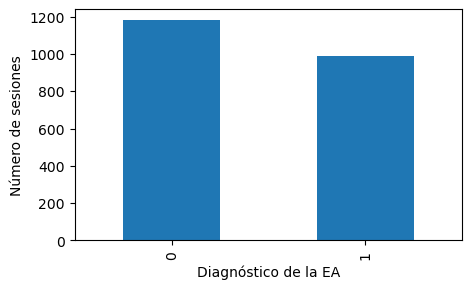

In [187]:
dfMR['BinaryDiag'].value_counts().plot(kind='bar')
plt.xlabel('Diagnóstico de la EA')
plt.ylabel('Número de sesiones')

In [188]:
dfMR

MR ID   Subject   Age  BinaryDiag  FirstPositiveDay  Cut  \
0     OAS30001_MR_d0129  OAS30001  65.0           0               0.0    1   
1     OAS30001_MR_d0757  OAS30001  67.0           0               0.0    1   
2     OAS30001_MR_d2430  OAS30001  71.0           0               0.0    1   
3     OAS30001_MR_d3132  OAS30001  73.0           0               0.0    1   
4     OAS30001_MR_d3746  OAS30001   NaN           0               0.0    1   
...                 ...       ...   ...         ...               ...  ...   
2168  OAS31170_MR_d2410  OAS31170  71.0           1             406.0    2   
2169  OAS31170_MR_d2410  OAS31170  71.0           1             406.0    3   
2170  OAS31170_MR_d2410  OAS31170  71.0           1             406.0    4   
2171  OAS31172_MR_d0407  OAS31172  72.0           0               0.0    1   
2172  OAS31172_MR_d1717  OAS31172  75.0           0               0.0    1   

                                                    IRM  
0     [[0.08560876808106123, 0.07664706380586876, 0....  
1     [[0.06254208016590311, 0.054417912302267654, 0...  
2     [[0.13628387391846555, 0.1273744751212903, 0.1...  
3     [[0.05013864924537897, 0.06588620930901747, 0....  
4     [[0.14313008908162178, 0.14313008908162178, 0....  
...                                                 ...  
2168  [[0.07104370791492645, 0.08491888220128395, 0....  
2169  [[0.05840332499062754, 0.058363974820864806, 0...  
2170  [[0.07331324707332865, 0.07611774524339412, 0....  
2171  [[0.05944883885340373, 0.059571961326406686, 0...  
2172  [[0.06198965979222807, 0.06670606993120831, 0....  

[2173 rows x 7 columns]

Se visualiza una matriz de IRM con diversidad en clases.

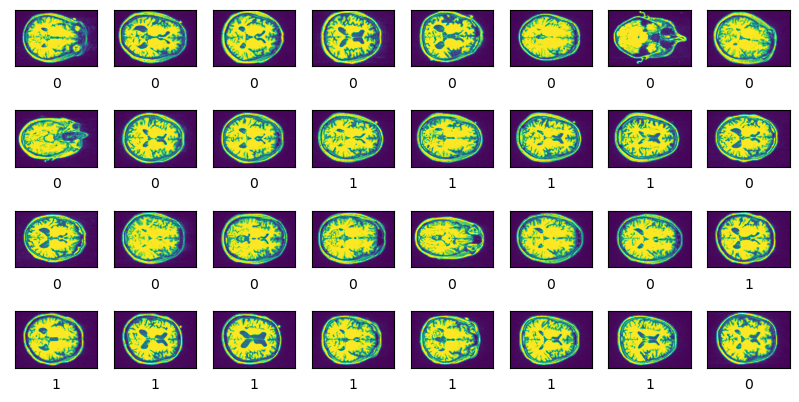

In [189]:
plt.figure(figsize=(10,5))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dfMR['IRM'][i+2140])
    plt.xlabel(dfMR['BinaryDiag'][i+2140])

### Aprendizaje

Solo se seleccionan para el conjunto de pruebas muestras de >=3 años de antelación.

> Se procura que sea aproximado al 20% del conjunto general.

In [201]:
yearsEarly = 3
daysEarly = 3 * 365

dfMREarly = dfMR[dfMR['FirstPositiveDay'] <= daysEarly]
dfMRLate = dfMR[dfMR['FirstPositiveDay'] > daysEarly]

earlySplitRatio = (dfMR.shape[0] * 0.2) / dfMREarly.shape[0]
print(earlySplitRatio)

0.24037610619469027


Se añade aleatoriedad, y se procede con los cortes para el entrenamiento y prueba.

También se reciclan las muestras de <3 años de antelación para el aprendizaje.

In [208]:
earlySplitCut = int(dfMREarly.shape[0] * (1 - earlySplitRatio))

dfMREarlyRandom = dfMREarly.sample(frac=1).reset_index(drop=True)
dfMRLateRandom = dfMRLate.sample(frac=1).reset_index(drop=True)

def getImagesForConvolution(images):
    imagesForConvolution = np.expand_dims(
        np.stack(np.array(images), axis=0),
        axis=-1
    )
    return imagesForConvolution

x_test = getImagesForConvolution(dfMREarlyRandom['IRM'])[earlySplitCut:]
y_test = dfMREarlyRandom['BinaryDiag'][earlySplitCut:]

x_trainEarly = getImagesForConvolution(dfMREarlyRandom['IRM'])[:earlySplitCut]
x_trainLate = getImagesForConvolution(dfMRLateRandom['IRM'])
x_train = np.concatenate((x_trainEarly, x_trainLate))

y_trainEarly = dfMREarlyRandom['BinaryDiag'][:earlySplitCut]
y_trainLate = dfMRLateRandom['BinaryDiag']
y_train = np.concatenate((y_trainEarly, y_trainLate))

Se define el modelo.

In [210]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(175, 255, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 173, 253, 32)      320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 86, 126, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 84, 124, 32)       9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 42, 62, 32)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 83328)             0         
                                                                 
 dense_33 (Dense)            (None, 64)              

In [211]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

training = model.fit(x_train, y_train, 
                    epochs=10, 
                    validation_data=(x_test, y_test))

Epoch 1/10


2022-09-13 18:49:42.837534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5852

2022-09-13 18:49:50.540554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 9s 148ms/step - loss: 0.6799 - accuracy: 0.5852 - val_loss: 0.5439 - val_accuracy: 0.7379
Epoch 2/10
55/55 [==============================] - 7s 130ms/step - loss: 0.4777 - accuracy: 0.7722 - val_loss: 0.3780 - val_accuracy: 0.8253
Epoch 3/10
55/55 [==============================] - 7s 127ms/step - loss: 0.3525 - accuracy: 0.8441 - val_loss: 0.3587 - val_accuracy: 0.8391
Epoch 4/10
55/55 [==============================] - 7s 127ms/step - loss: 0.2707 - accuracy: 0.8878 - val_loss: 0.4911 - val_accuracy: 0.7954
Epoch 5/10
55/55 [==============================] - 7s 127ms/step - loss: 0.2125 - accuracy: 0.9241 - val_loss: 0.5149 - val_accuracy: 0.7931
Epoch 6/10
55/55 [==============================] - 7s 130ms/step - loss: 0.1648 - accuracy: 0.9396 - val_loss: 0.5289 - val_accuracy: 0.7977
Epoch 7/10
55/55 [==============================] - 7s 127ms/step - loss: 0.0995 - accuracy: 0.9672 - val_loss: 0.4242 - val_accuracy: 0.8437
Epoch 8/10
55/55 

### Evaluación

Evolución de pérdida y exactitud. Buena impresión:

- La exactitud sube.
- La pérdida baja.

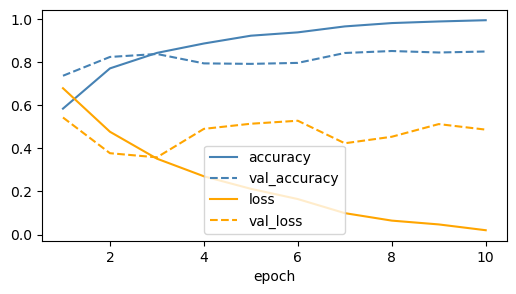

In [224]:
fig = plt.figure(figsize=(6, 3))
epoch = np.arange(10) + 1
plt.plot(epoch, training.history['accuracy'],
         color='steelblue', label='accuracy')
plt.plot(epoch, training.history['val_accuracy'], linestyle='--',
         color='steelblue', label='val_accuracy')
plt.plot(epoch, training.history['loss'],
         color='orange', label='loss')
plt.plot(epoch, training.history['val_loss'], linestyle='--',
         color='orange', label='val_loss')
plt.xlabel('epoch')
plt.legend()

Evaluación del conjunto de prueba. Buena impresión:

- Exactitud del 85% (mayor al 65% esperado).

In [225]:
evaluation = model.evaluate(x_test, y_test)

14/14 [==============================] - 1s 60ms/step - loss: 0.4875 - accuracy: 0.8506


Curva ROC

In [256]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

def plotRoc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

y_predict = np.round(model.predict(x_test)).tolist()

14/14 [==============================] - 1s 64ms/step


Área bajo la curva. Parece buena:

- 83% de probabilidad de que pueda distinguir entre clases.

In [257]:
roc_auc_score(y_test, y_predict) * 100

83.02570412906755

Curva ROC. Buena forma:

- Por encima y alejada de la diagonal principal.

Text(0.5, 0, 'Ratio de falsos positivos')

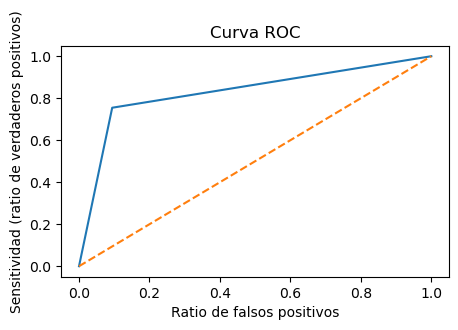

In [259]:
falsePositive, truePositive, threshold = roc_curve(y_test, y_predict)

plt.title('Curva ROC')
plt.plot(falsePositive, truePositive)
plt.plot([0, 1], ls="--")
plt.ylabel('Sensitividad (ratio de verdaderos positivos)')
plt.xlabel('Ratio de falsos positivos')

Matriz de confusión

Text(0.5, 3.722222222222216, 'Clasificación predicha')

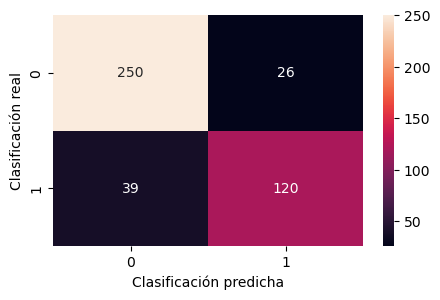

In [268]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt='g')
plt.ylabel('Clasificación real')
plt.xlabel('Clasificación predicha')